In [8]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.tsa.vector_ar.vecm as vecm
import numpy as np

In [9]:
import warnings

# Ignore DeprecationWarning and RuntimeWarning
warnings.filterwarnings("ignore")


In [10]:
data_df = pd.read_excel(r'/Users/dhruvpandit/Documents/GitHub/Projects/macrodata.xlsm', index_col='Date')

In [11]:
data_df.rename(columns={' GBP-EOM-VAL-CUR':'GBP',
                            'USD-EOM-VAL-CUR': 'USD',
                            'CPI-YOY-ROC-PERC': 'CPI',
                            'IR-L-IND-CONCRED-PERC' : 'IR-C', 'IR-L-IND-HOU-PERC' : 'IR-H',
       'GAC-BM-MIL-EUR':'GAC'}, inplace=True)
data_df['GAC'] = data_df['GAC'] / 1000
data_df['USD'] = data_df['USD'] / 10000
data_df['GBP_d'] = data_df['GBP'].diff()
data_df['USD_d'] = data_df['USD'].diff()
data_df['CPI_d'] = data_df['CPI'].diff()
data_df['IR-C_d'] = data_df['IR-C'].diff()
data_df['IR-H_d'] = data_df['IR-H'].diff()
data_df['GAC_d'] = data_df['GAC'].diff()
data_df.dropna(inplace=True)

In [12]:
data_df

,GBP,USD,CPI,IR-C,IR-H,GAC,GBP_d,USD_d,CPI_d,IR-C_d,IR-H_d,GAC_d
Date,,,,,,,,,,,,
2003-02-28,0.68420,1.078200,4.1,9.86,4.25,-754.55,0.02850,-0.003400,0.1,-0.05,-0.15,105.06
2003-03-31,0.68960,1.089500,3.7,9.73,4.08,-1202.52,0.00540,0.011300,-0.4,-0.13,-0.17,-447.97
2003-04-30,0.69700,1.113100,3.7,10.05,4.02,-774.65,0.00740,0.023600,0.0,0.32,-0.06,427.87
2003-05-31,0.71960,1.182200,3.6,10.26,4.03,-1006.67,0.02260,0.069100,-0.1,0.21,0.01,-232.02
2003-06-30,0.69320,1.142700,3.3,9.87,3.70,-1178.10,-0.02640,-0.039500,-0.3,-0.39,-0.33,-171.43
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31,0.86115,0.000099,10.1,8.06,2.86,-2346.59,-0.02185,0.000002,0.8,0.21,0.63,42.16
2022-11-30,0.86488,1.037600,9.9,7.98,3.09,-2042.42,0.00373,1.037501,-0.2,-0.08,0.23,304.17
2022-12-31,0.88693,1.066600,9.6,7.97,3.24,-2453.69,0.02205,0.029000,-0.3,-0.01,0.15,-411.27


In [29]:
# Define the lag length
lags = 2
# Split the data into training and testing sets (e.g., 80% for training and 20% for testing)
nobs = int(len(data_df) * 0.9)
train, test = data_df[0:nobs], data_df[nobs:]

# Define the variables and their order (CPI is the dependent variable)
y_vars_d = ['CPI_d']
x_vars_d = ['GBP_d',
 'USD_d',
 'IR-C_d',
 'IR-H_d',
 'GAC_d']
y_vars = ['CPI']
x_vars = ['GBP',
 'USD',
 'IR-C',
 'IR-H',
 'GAC']
vars_order = y_vars+x_vars
vars_order_d = y_vars_d+x_vars_d


## Data Exploration

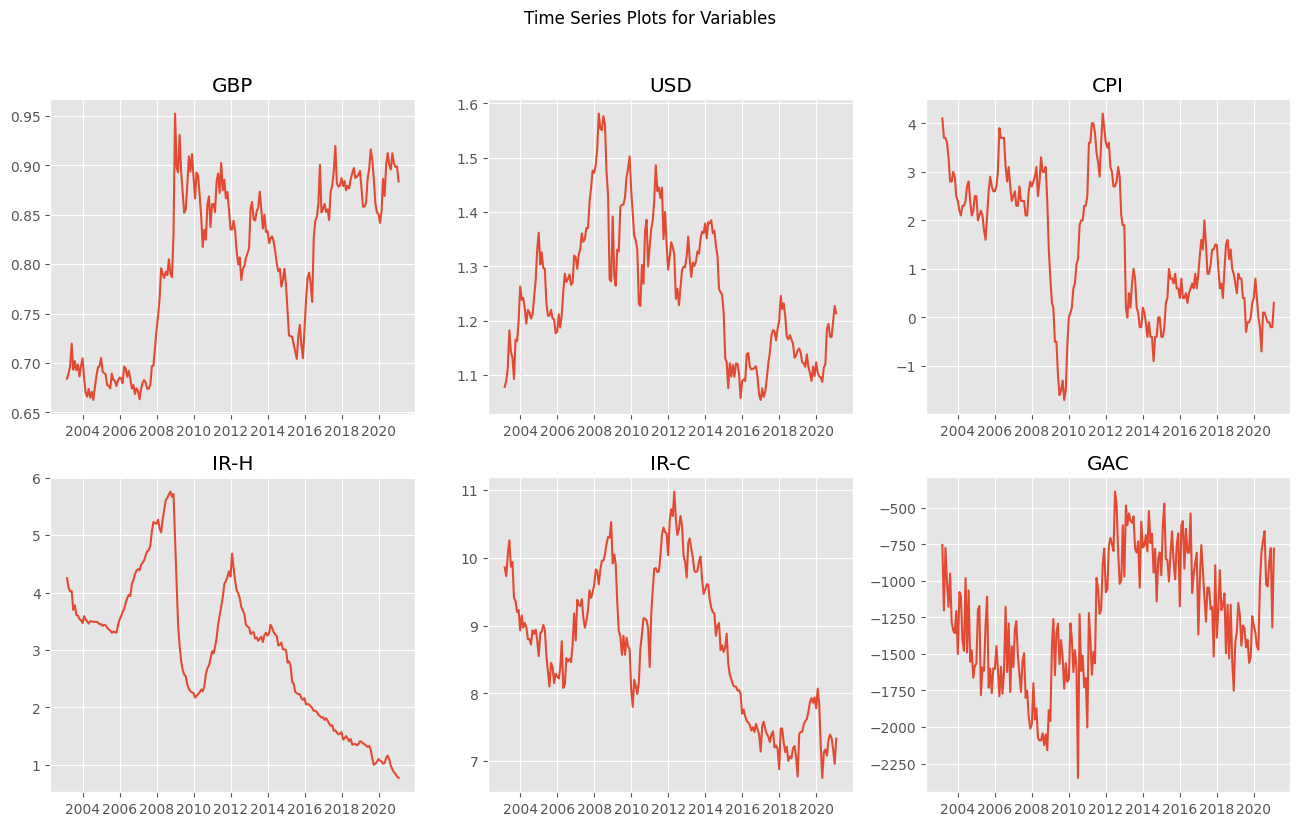

In [14]:
x = train.index
plt.style.use('ggplot')
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))
# Plot the data on each individual subplot
axs[0, 0].plot(train['GBP'])
axs[0, 1].plot(train['USD'])
axs[0, 2].plot(train['CPI'])
axs[1, 0].plot(train['IR-H'])
axs[1, 1].plot(train['IR-C'])
axs[1, 2].plot(train['GAC'])

# Set the titles for each subplot
axs[0, 0].set_title('GBP')
axs[0, 1].set_title('USD')
axs[0, 2].set_title('CPI')
axs[1, 0].set_title('IR-H')
axs[1, 1].set_title('IR-C')
axs[1, 2].set_title('GAC')

# Add a main title for the entire figure
fig.suptitle('Time Series Plots for Variables')

# Show the figure
plt.show()


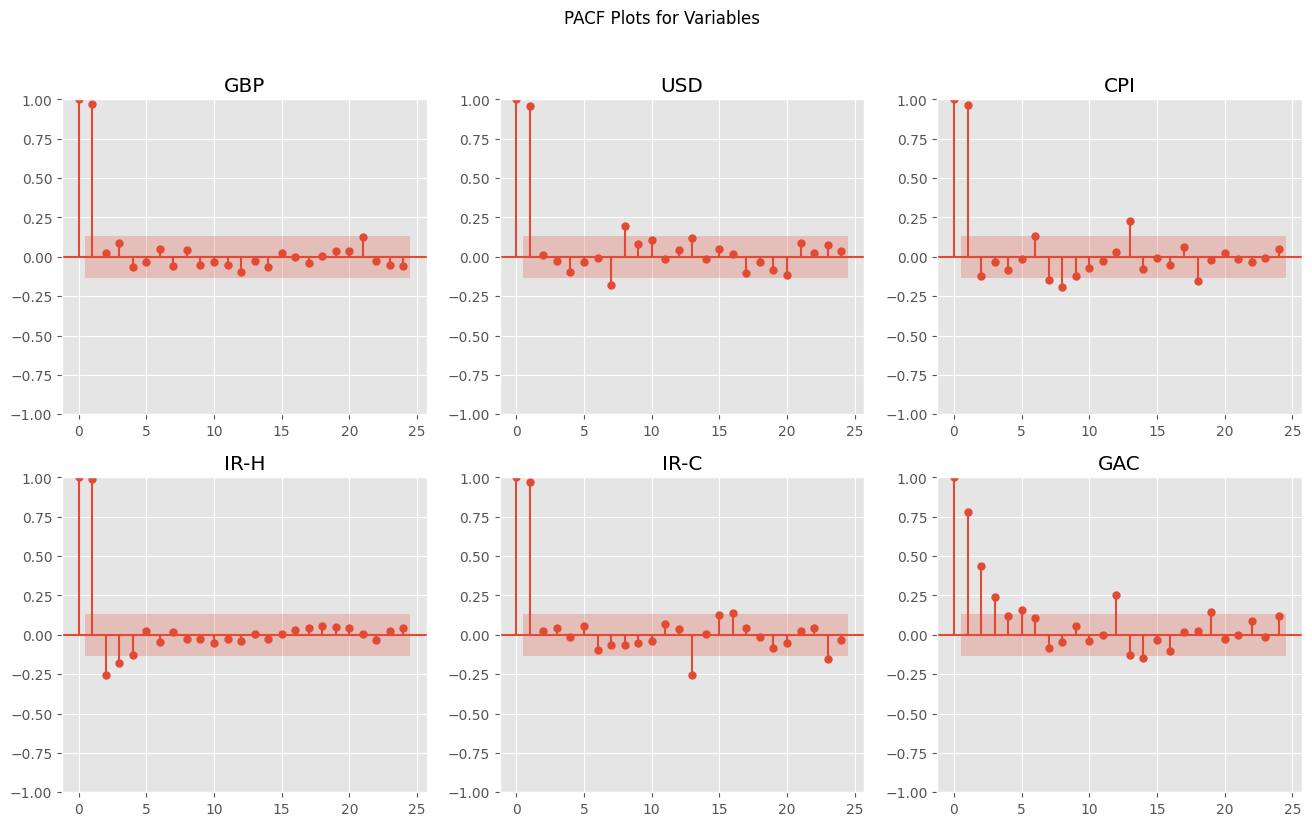

In [15]:
x = train.index
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))
# Plot the data on each individual subplot
plot_pacf(train['GBP'], ax=axs[0, 0])
plot_pacf(train['USD'], axs[0, 1])
plot_pacf(train['CPI'], axs[0, 2])
plot_pacf(train['IR-H'], axs[1, 0])
plot_pacf(train['IR-C'], axs[1, 1])
plot_pacf(train['GAC'], axs[1, 2])

# Set the titles for each subplot
axs[0, 0].set_title('GBP')
axs[0, 1].set_title('USD')
axs[0, 2].set_title('CPI')
axs[1, 0].set_title('IR-H')
axs[1, 1].set_title('IR-C')
axs[1, 2].set_title('GAC')

# Add a main title for the entire figure
fig.suptitle('PACF Plots for Variables')

# Show the figure
plt.show()


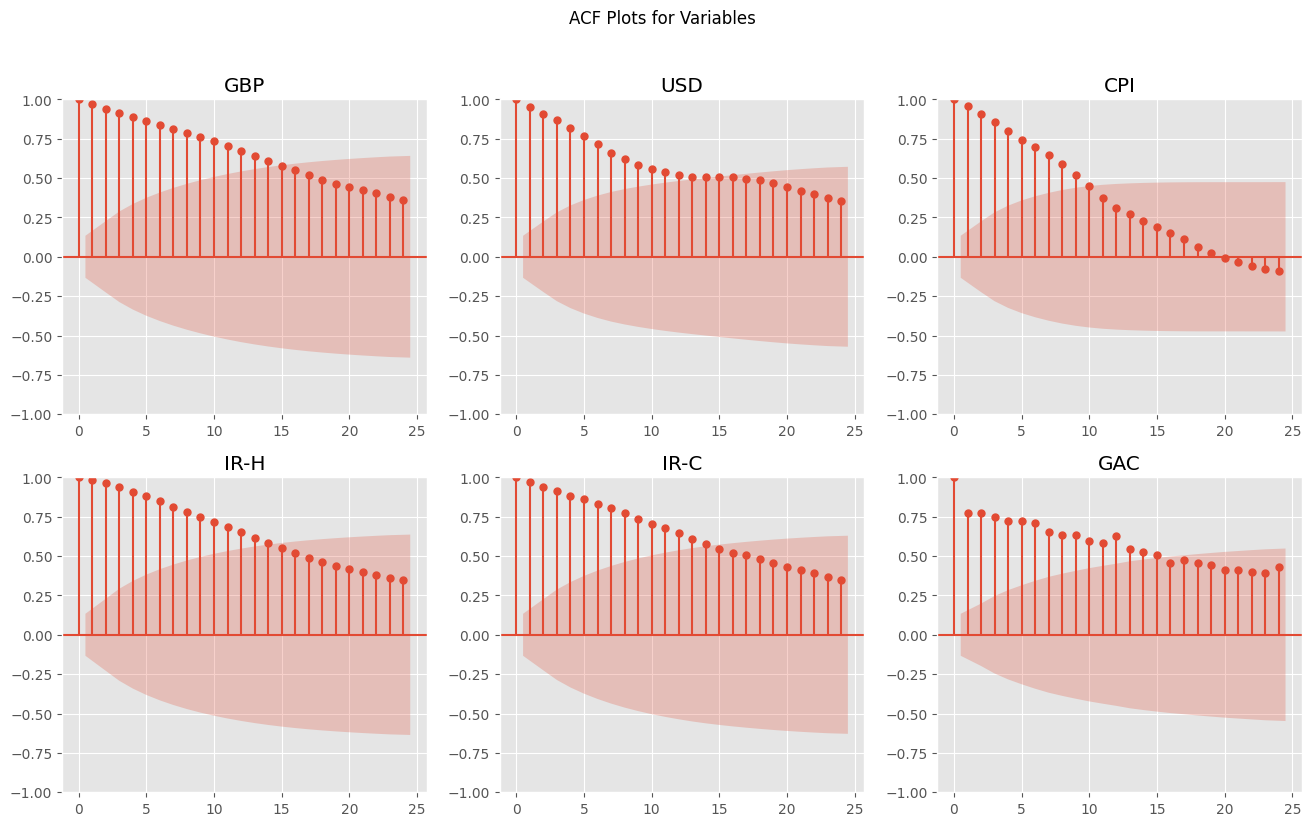

In [16]:
x = train.index
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))
# Plot the data on each individual subplot
plot_acf(train['GBP'], ax=axs[0, 0])
plot_acf(train['USD'], axs[0, 1])
plot_acf(train['CPI'], axs[0, 2])
plot_acf(train['IR-H'], axs[1, 0])
plot_acf(train['IR-C'], axs[1, 1])
plot_acf(train['GAC'], axs[1, 2])

# Set the titles for each subplot
axs[0, 0].set_title('GBP')
axs[0, 1].set_title('USD')
axs[0, 2].set_title('CPI')
axs[1, 0].set_title('IR-H')
axs[1, 1].set_title('IR-C')
axs[1, 2].set_title('GAC')

# Add a main title for the entire figure
fig.suptitle('ACF Plots for Variables')

# Show the figure
plt.show()

## ADF Test

In [17]:
def adf_test(column, sig_level):
    # Perform ADF test on the column
    result = adfuller(column)
    
    # Extract the ADF test statistic and p-value
    adf_stat = result[0]
    p_value = result[1]
    
    # Check if the p-value is less than the significance level
    if p_value < sig_level:
        return adf_stat, p_value, "Series is Stationary"
    else:
        return adf_stat, p_value, "Series is non-stationary"


In [18]:
for col in data_df.columns:
    result = adf_test(data_df[col], 0.05)
    print(f"{col}: ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] < 0.05:
        print("Series is Stationary")
    else:
        print("Series is non-stationary")
    print()

GBP: ADF Statistic: -1.9577735521857214, p-value: 0.3053891276979571
Series is non-stationary

USD: ADF Statistic: -1.547749845861523, p-value: 0.50977198143299
Series is non-stationary

CPI: ADF Statistic: -2.2628840172986204, p-value: 0.18421808443316612
Series is non-stationary

IR-C: ADF Statistic: -1.7588595382115486, p-value: 0.4010694654744219
Series is non-stationary

IR-H: ADF Statistic: -2.260211288479511, p-value: 0.1851217844998307
Series is non-stationary

GAC: ADF Statistic: -2.135353192418848, p-value: 0.23053849563426398
Series is non-stationary

GBP_d: ADF Statistic: -8.800002193142214, p-value: 2.1249235162322548e-14
Series is Stationary

USD_d: ADF Statistic: -12.736105139647984, p-value: 9.153643058395453e-24
Series is Stationary

CPI_d: ADF Statistic: -5.337871156667616, p-value: 4.568561581406367e-06
Series is Stationary

IR-C_d: ADF Statistic: -4.045741876644066, p-value: 0.0011890513965829958
Series is Stationary

IR-H_d: ADF Statistic: -4.6935134925601405, p-va

In [79]:
train.index[-1]
test.index[0]


Timestamp('2021-02-28 00:00:00')

## CoInt Test

In [35]:
vec_rank1 = vecm.select_coint_rank(train[vars_order], det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.05)
print(vec_rank1.summary())

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   6          157.9          107.3
  1   6          89.06          79.34
  2   6          54.30          55.25
-------------------------------------


In [34]:
vec_rank1 = vecm.select_coint_rank(train[vars_order], det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.05)
print(vec_rank1.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          68.83          43.42
  1   2          34.76          37.16
-------------------------------------


## Granger Causality

In [28]:
import statsmodels.api as sm
import itertools

# Perform pairwise Granger causality tests
for var1, var2 in itertools.permutations(vars_order_d, 2):
    # Create a new dataframe with only the two variables
    data = data_df[[var1, var2]]
    # Fit a VAR model with lag order 1
    model = sm.tsa.VAR(data)
    results = model.fit(1)
    # Perform the Granger causality test
    gc_result = results.test_causality(var2, var1, kind='f')
    # Print the results
    print(gc_result.summary())
    # print(f"{var2} Granger causes {var1} with F-statistic = {gc_result['F']} and p-value = {gc_result['pvalue']}")


Granger causality F-test. H_0: CPI_d does not Granger-cause GBP_d. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.688          3.861   0.195 (1, 474)
----------------------------------------------
Granger causality F-test. H_0: CPI_d does not Granger-cause USD_d. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.395          3.861   0.122 (1, 474)
----------------------------------------------
Granger causality F-test. H_0: CPI_d does not Granger-cause IRD-C_d. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.1227          3.861   0.726 (1, 474)
----------------------------------------------
Granger causality F-test. H_0: CPI_d does not Granger-cause IR

In [29]:
# Estimate the optimal lag length using AIC
vecm_order = vecm.select_order(train[vars_order], maxlags = 10)
vecm_order.summary()

,AIC,BIC,FPE,HQIC
0,-13.22,-12.54*,1.822e-06,-12.94*
1,-13.44,-12.17,1.459e-06,-12.93
2,-13.46*,-11.61,1.433e-06*,-12.71
3,-13.41,-10.97,1.517e-06,-12.42
4,-13.29,-10.27,1.716e-06,-12.07
5,-13.25,-9.650,1.806e-06,-11.79
6,-13.17,-8.990,1.976e-06,-11.48
7,-13.10,-8.330,2.173e-06,-11.17
8,-12.97,-7.617,2.536e-06,-10.80
9,-12.93,-6.995,2.717e-06,-10.53


In [21]:
from statsmodels.tsa.api import VECM
model = VECM(train[['CPI','GBP', 'USD', 'IR-H', 'IR-C', 'GAC']], k_ar_diff=0, coint_rank=1)
result = model.fit()
result.summary()


,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0188,0.017,1.113,0.266,-0.014,0.052
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0016,0.001,-1.817,0.069,-0.003,0.000
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0024,0.002,-1.462,0.144,-0.006,0.001
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0548,0.005,10.856,0.000,0.045,0.065
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0343,0.011,3.103,0.002,0.013,0.056
,coef,std err,z,P>|z|,[0.025,0.975]


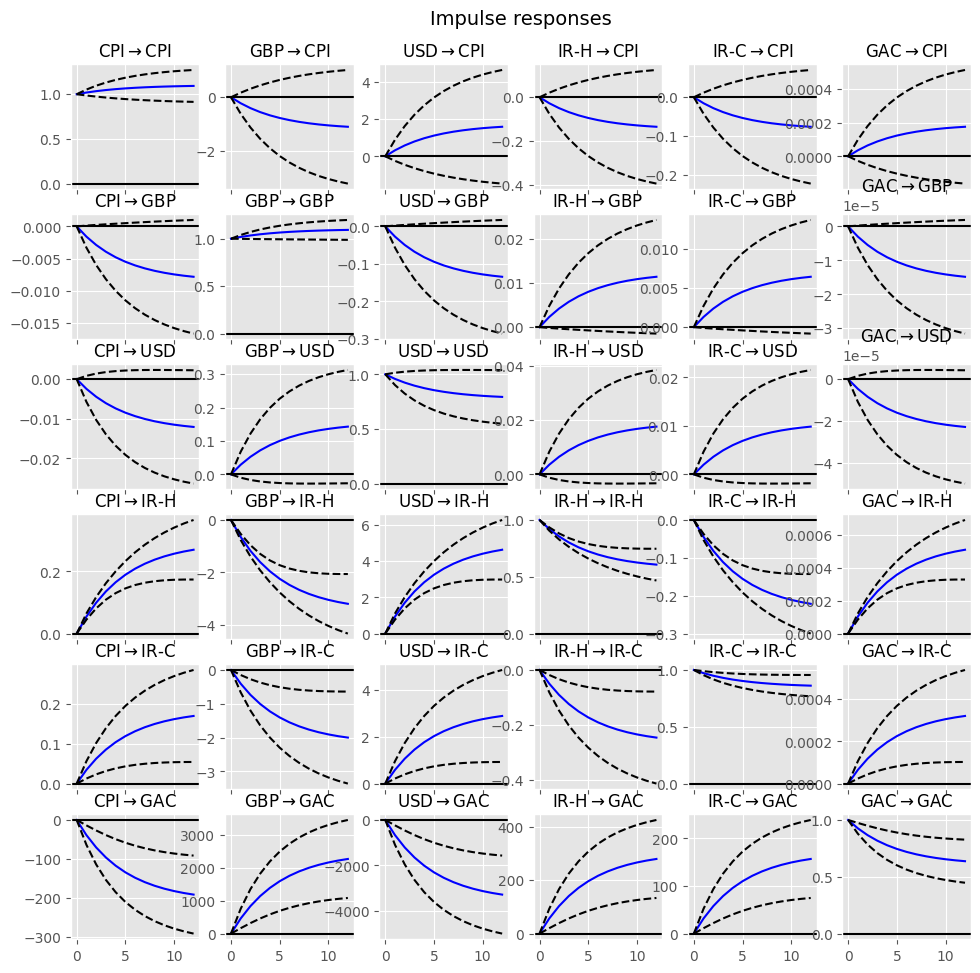

In [22]:

# stores and prints the impulse response functions
irf = result.irf(12)
irf_p = irf.plot(orth = False)



In [31]:
pred = result.predict(len(test.index))
pred = pd.DataFrame({
    'GBP' : pred[:,0],
    'USD' : pred[:,1],
    'CPI' : pred[:,2],
    'IR-H' : pred[:,3],
    'IR-C': pred[:,4],
    'GAC': pred[:,5]
})
pred.set_index(test.index, inplace = True)

In [30]:
def rmse(y_true, y_pred):
    """
    Calculate root mean squared error (RMSE) between two series.
    
    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.
    
    Returns:
        float: RMSE between two series.
    """
    return np.sqrt(np.mean(np.square(y_pred - y_true)))
rmse_list = []
for column in vars_order:
    print(column)
    rmse_list.append(rmse(test[column].values, pred[column]))
    print(rmse(test[column].values, pred[column]))

CPI
5.259185992583567
GBP
0.388721193411242
USD
0.3478733063554907
IR-C
0.31570969977606567
IR-H
0.9097450851448295
GAC
809.3309230476702


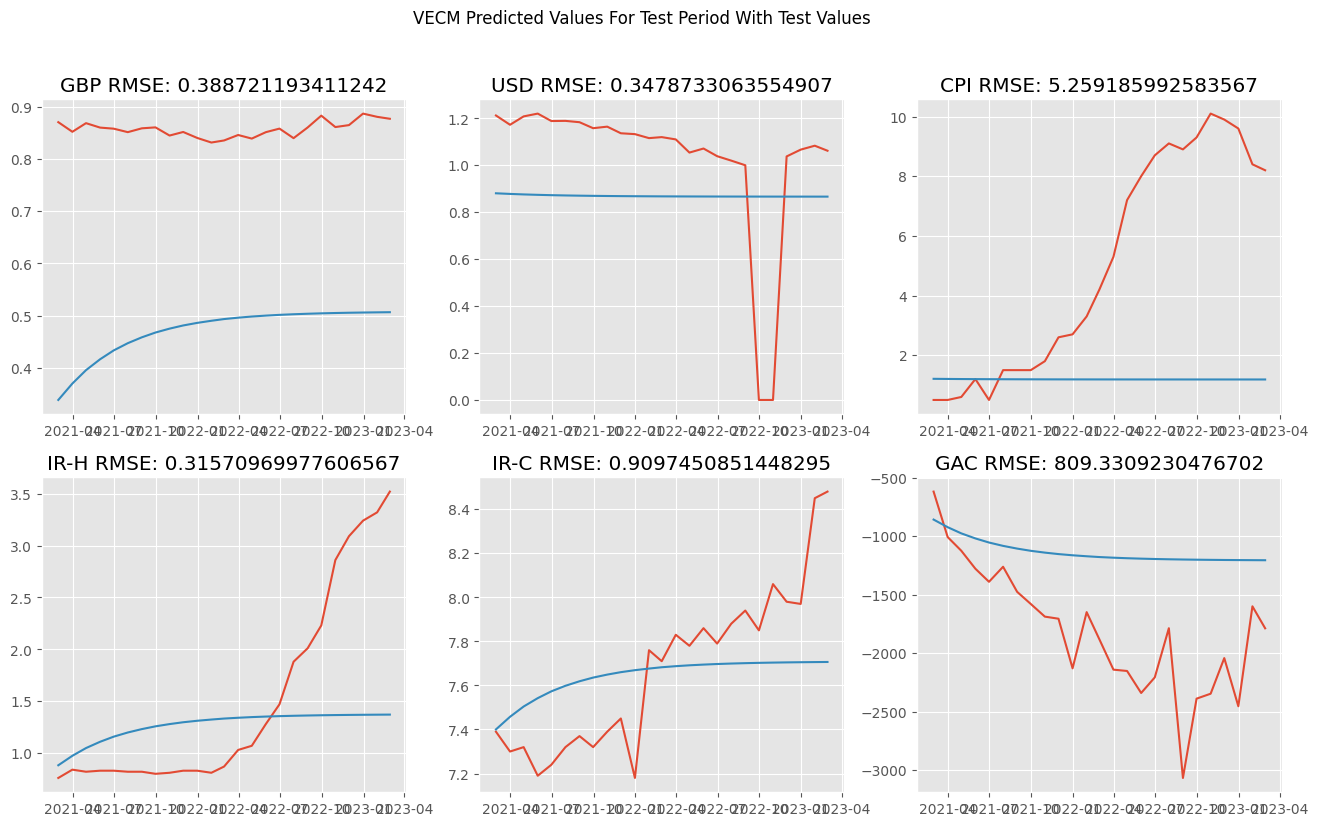

In [35]:
x = test.index
plt.style.use('ggplot')
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))
# Plot the data on each individual subplot
axs[0, 0].plot(test['GBP'])
axs[0, 0].plot(pred['GBP'])

axs[0, 1].plot(test['USD'])
axs[0, 1].plot(pred['USD'])

axs[0, 2].plot(test['CPI'])
axs[0, 2].plot(pred['CPI'])

axs[1, 0].plot(test['IR-H'])
axs[1, 0].plot(pred['IR-H'])

axs[1, 1].plot(test['IR-C'])
axs[1, 1].plot(pred['IR-C'])

axs[1, 2].plot(test['GAC'])
axs[1, 2].plot(pred['GAC'])

# Set the titles for each subplot
axs[0, 0].set_title('GBP RMSE: ' + str(rmse_list[1]))
axs[0, 1].set_title('USD RMSE: '+ str(rmse_list[2]))
axs[0, 2].set_title('CPI RMSE: '+ str(rmse_list[0]))
axs[1, 0].set_title('IR-H RMSE: '+ str(rmse_list[3]))
axs[1, 1].set_title('IR-C RMSE: '+ str(rmse_list[4]))
axs[1, 2].set_title('GAC RMSE: '+ str(rmse_list[5]))
# Add a main title for the entire figure
fig.suptitle('VECM Predicted Values (Blue) For Test Period With Test Values (Orange)')

# Show the figure
plt.show()


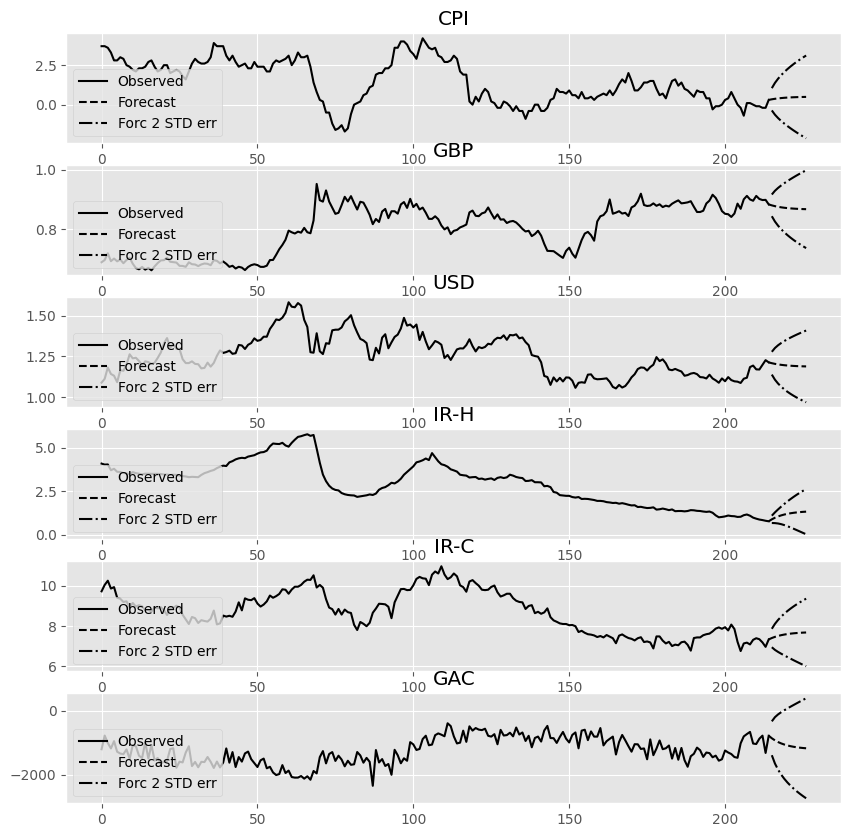

In [33]:
result.plot_forecast(12)

In [60]:
import statsmodels.tsa.ardl as ardl

order = ardl.ardl_select_order(train[y_vars_d], exog = train[x_vars_d], ic='aic', maxlag=5, maxorder=5)
print(order.ar_lags)
print(order.dl_lags)

None
{'GBP_d': [0], 'IR-H_d': [0, 1]}


In [62]:
ardl_model = ardl.ARDL(train[y_vars_d], exog=train[x_vars_d], lags = order.ar_lags,  order = {'GBP_d': [0], 'IR-H_d': [0, 1]}, trend = order.trend).fit()
ardl_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                  CPI_d   No. Observations:                  216
Model:                  ARDL(0, 0, 1)   Log Likelihood                 -78.661
Method:               Conditional MLE   S.D. of innovations              0.348
Date:                Wed, 10 May 2023   AIC                            167.322
Time:                        22:43:52   BIC                            184.198
Sample:                    03-31-2003   HQIC                           174.140
                         - 01-31-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0046      0.024     -0.190      0.849      -0.053       0.043
GBP_d.L0      -2.1508      1.293     -1.663      0.098      -4.700       0.399
IR-H_d.L0      0.1908      0.216      0.882      0.379      -0.236       0.617
IR-H_d.L1      0.4757      0.217      2.197      0.029       0.049       0.903
==============================================================================
"""

In [64]:
ardl_pred = ardl_model.predict(start = test.index[0], end = test.index[-1], exog = train[x_vars_d], exog_oos=test[x_vars_d])

In [82]:
undiff_pred_2 = test['CPI'] + np.cumsum(ardl_pred)

Date
2021-02-28     0.507802
2021-03-31     0.553345
2021-04-30     0.647386
2021-05-31     1.253438
2021-06-30     0.558044
2021-07-31     1.565814
2021-08-31     1.540625
2021-09-30     1.528356
2021-10-31     1.849743
2021-11-30     2.639002
2021-12-31     2.768517
2022-01-31     3.378896
2022-02-28     4.267668
2022-03-31     5.399637
2022-04-30     7.393529
2022-05-31     8.221546
2022-06-30     9.038398
2022-07-31     9.641740
2022-08-31     9.612967
2022-09-30    10.063442
2022-10-31    11.130665
2022-11-30    11.261583
2022-12-31    11.047561
2023-01-31     9.942888
2023-02-28     9.822479
dtype: float64

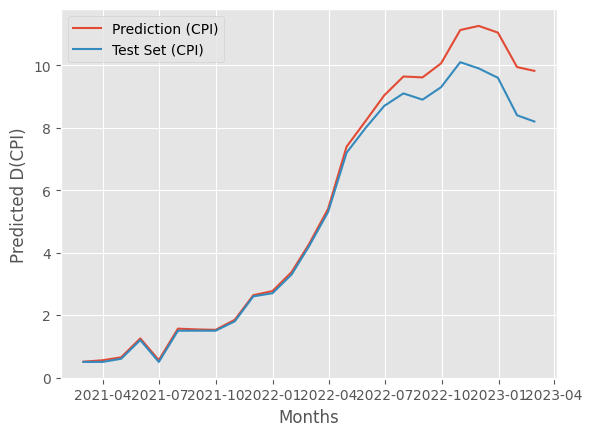

In [83]:
plt.plot(test.index, undiff_pred_2.values, label='Prediction (CPI)')
plt.plot(test.index, test[y_vars], label='Test Set (CPI)')

# add a legend
plt.legend()

# add x and y axis labels
plt.xlabel('Months')
plt.ylabel('Predicted (CPI)')
plt.title('ARDL Predicted Values For CPI For Test Period With Test Values')

# show the plot
plt.show()

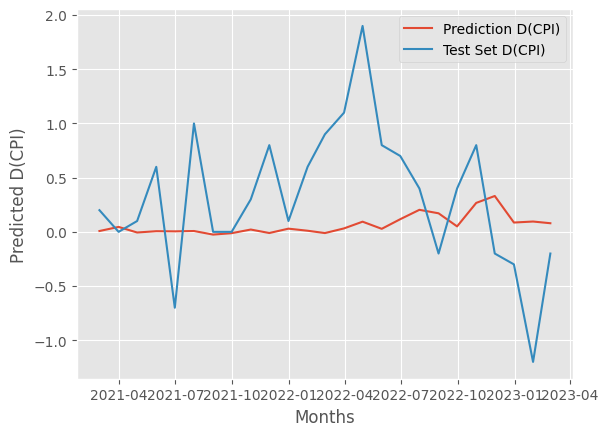

In [66]:
plt.plot(test.index,ardl_pred.values , label='Prediction D(CPI)')
plt.plot(test.index, test[y_vars_d], label='Test Set D(CPI)')

# add a legend
plt.legend()

# add x and y axis labels
plt.xlabel('Months')
plt.ylabel('Predicted D(CPI)')
plt.title('ARDL Predicted Values For D(CPI) For Test Period With Test Values')

# show the plot
plt.show()

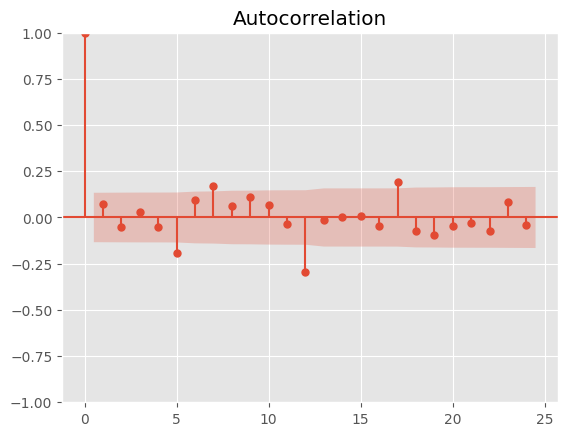

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(ardl_model.resid)

In [68]:
model_ucem = ardl.UECM(train[y_vars_d], exog = train[x_vars_d], lags = 1, trend=order.trend, order = 1).fit()


In [72]:
model_ucem.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                UECM Model Results                                
==================================================================================
Dep. Variable:                    D.CPI_d   No. Observations:                  216
Model:             UECM(1, 1, 1, 1, 1, 1)   Log Likelihood                 -76.017
Method:                   Conditional MLE   S.D. of innovations              0.497
Date:                    Wed, 10 May 2023   AIC                            178.034
Time:                            22:46:39   BIC                            221.852
Sample:                        03-31-2003   HQIC                           195.739
                             - 01-31-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0031      0.025     -0.127      0.899      -0.051       0.045
CPI_d.L1        -0.9256      0.070    -13.186      0.000      -1.064      -0.787
GBP_d.L1        -3.2279      2.136     -1.511      0.132      -7.440       0.984
USD_d.L1         0.2478      1.077      0.230      0.818      -1.876       2.372
IRD-C_d.L1       0.1211      0.158      0.765      0.445      -0.191       0.433
IR-H_d.L1        0.5350      0.227      2.358      0.019       0.088       0.982
GAC_d.L1        -0.0001      0.000     -0.807      0.420      -0.000       0.000
D.GBP_d.L0      -2.7325      1.522     -1.796      0.074      -5.733       0.268
D.USD_d.L0       0.5768      0.781      0.739      0.461      -0.963       2.117
D.IRD-C_d.L0     0.0485      0.107      0.455      0.649      -0.162       0.259
D.IR-H_d.L0      0.1254      0.230      0.544      0.587      -0.329       0.580
D.GAC_d.L0   -3.262e-06      0.000     -0.032      0.975      -0.000       0.000
================================================================================
"""

In [73]:
model_ucem.bounds_test(2, cov_type = 'HC0')

BoundsTestResult
Stat: 35.07280
Upper P-value: 0
Lower P-value: 0
Null: No Cointegration
Alternative: Possible Cointegration

In [74]:
model_ucem.bounds_test(2, cov_type = 'HAC', cov_kwds = {'maxlags' : 1})

BoundsTestResult
Stat: 39.31351
Upper P-value: 0
Lower P-value: 0
Null: No Cointegration
Alternative: Possible Cointegration

In [75]:
model_ucem.bounds_test(3, cov_type = 'HAC', cov_kwds = {'maxlags' : 1})

BoundsTestResult
Stat: 44.74885
Upper P-value: 0
Lower P-value: 0
Null: No Cointegration
Alternative: Possible Cointegration

In [76]:
model_ucem.bounds_test(4, cov_type = 'HAC', cov_kwds = {'maxlags' : 1})

BoundsTestResult
Stat: 38.68944
Upper P-value: 0
Lower P-value: 0
Null: No Cointegration
Alternative: Possible Cointegration